# 도로 혼잡 예측 모델 구축 프로젝트

## 프로젝트 목표
서울시 도로별 통행속도와 지점별 교통량 데이터를 활용하여 도로의 혼잡 상태(원활, 지체, 정체)를 예측하는 머신러닝 모델 구축 

##  결과 요약
- **데이터 분석**: 도로별 통행속도와 지점별 교통량 데이터를 병합하여 일자별, 시간대별 혼잡 상태를 분석.
- **모델 구축**: PySpark의 MLlib을 활용
- **모델 평가**
- **활용 가능성**: 특정 도로의 시간대별 혼잡 상태를 예측하여 실시간 교통 관리에 기여.

##  아키텍처 정의

1. **데이터 수집 및 준비**
   - 데이터: 서울시 도로별 통행속도(1월~11월), 지점별 교통량(1월~11월).
   - 병합: 날짜(`date`)를 기준으로 두 데이터를 병합.

2. **데이터 전처리**
   - 결측치 처리 및 이상치 제거.
   - 혼잡 상태 라벨링(원활, 지체, 정체).

3. **모델 학습 및 평가**
   - 입력 변수: `avg_speed`(평균 속도), `traffic_volume`(교통량).
   - 출력 변수: `traffic_status`(혼잡 상태).
   - MLlib 모델 활용.

4. **결과 저장 및 시각화**
   - 예측 결과 저장 및 모델 성능 시각화.

## 환경 구축
### 4.1 개발 환경
- **운영체제**: Windows 10 
- **프로그래밍 언어**: Python 
- **분석 환경**: Jupyter Notebook.
- **주요 라이브러리**:
  - PySpark: 데이터 처리 및 머신러닝.
  - Pandas: 데이터 로드 및 초기 탐색.
  - Matplotlib/Seaborn: 시각화.


##  개발 계획
### 1 데이터 로드 및 전처리
1. **데이터 로드**:
   - 통행속도 데이터와 교통량 데이터를 불러옴.
2. **병합 및 전처리**:
   - 두 데이터를 `date`를 기준으로 병합.
   - 결측치 처리 및 이상치 제거.
   - `avg_speed`를 기반으로 혼잡 상태(`traffic_status`) 생성.

### 2 모델 학습 및 평가
1. **데이터 준비**:
   - `VectorAssembler`를 사용하여 `avg_speed`와 `traffic_volume`을 `features`로 변환.
   - `StringIndexer`로 `traffic_status`를 라벨 인코딩.
2. **Random Forest 모델 학습**:
   - PySpark MLlib의 `RandomForestClassifier` 사용.
   - 데이터셋을 80% 학습, 20% 테스트로 분리.
3. **모델 평가**:
   - 정확도(Accuracy), F1-score 계산.

### 3 결과 시각화 및 저장
- 예측 결과를 시각화하여 혼잡 상태 분포와 모델 성능 분석.
- 결과 데이터를 CSV로 저장.

##  테스트 계획
### 1 테스트 시나리오
1. **데이터 정합성 테스트**:
   - 병합된 데이터에서 결측치와 이상치 확인.
2. **모델 성능 테스트**:
   - 테스트 데이터로 모델의 예측 정확도 확인.
3. **시각화 결과 테스트**:
   - 시각화 그래프에서 혼잡 상태 분포가 논리적인지 확인.

### 2 성능 목표
- 정확도: 80% 이상.
- F1-score: 75% 이상.

##  보고서 작성 및 제출
- 분석 내용과 모델 결과를 Markdown 형식으로 정리하여 GitHub에 업로드.
- 주요 내용:
  - 데이터 설명.
  - 모델 구축 과정.
  - 성능 평가 결과.


In [14]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql.functions import col, sum

In [3]:
spark = SparkSession.builder.appName("SeoulTrafficAnalysis").getOrCreate()

24/12/19 11:01:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [116]:
# 파일경로 설정 
import os
speed_files= '/speed/*'
volume_file= '/traffic/*'
mapping_file= '서울시 표준링크 매핑정보.csv'
directory = os.path.join(os.getcwd(), 'data')

In [117]:
# 데이터 로드 
speed_df= spark.read.csv(f'file:///{directory}/{speed_files}', inferSchema=True, header=True)
volume_df= spark.read.csv(f'file:///{directory}/{volume_file}', inferSchema=True, header=True)
mapping_df= spark.read.csv(f'file:///{directory}/{mapping_file}', inferSchema=True, header=True)


In [118]:
mapping_df.show(5)

+----------+--------------+
|서비스링크|표준링크아이디|
+----------+--------------+
|1040004100|    1040004101|
|1040002100|    1040002102|
|1040001500|    1040001502|
|1040001500|    1040001501|
|1040001100|    1040001104|
+----------+--------------+
only showing top 5 rows



# 속도 데이터

## 서울시 차량통행속도 데이터

### 수집기간 : 2024년 01 ~ 10월, 24시간 (00~24시)

#### Topis 서울시 도로별 일자별 통행속도 데이터 중 2021년 01~06월까지 데이터 다운 후, csv 변환
#### 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향(상/하행), 거리, 차선수,기능유형구분(보조간선도로/기타도로) , 도심/외곽구분, 권역구분, 시간대별 속도로 구성


In [121]:
speed_df.printSchema()

root
 |-- 일자: integer (nullable = true)
 |-- 요일: string (nullable = true)
 |-- 도로명: string (nullable = true)
 |-- 링크아이디: string (nullable = true)
 |-- 시점명: string (nullable = true)
 |-- 종점명: string (nullable = true)
 |-- 방향: string (nullable = true)
 |-- 거리: string (nullable = true)
 |-- 차선수: string (nullable = true)
 |-- 기능유형구분: string (nullable = true)
 |-- 도심/외곽구분: string (nullable = true)
 |-- 권역구분: string (nullable = true)
 |-- ~01시: string (nullable = true)
 |-- ~02시: string (nullable = true)
 |-- ~03시: string (nullable = true)
 |-- ~04시: string (nullable = true)
 |-- ~05시: string (nullable = true)
 |-- ~06시: string (nullable = true)
 |-- ~07시: string (nullable = true)
 |-- ~08시: string (nullable = true)
 |-- ~09시: string (nullable = true)
 |-- ~10시: string (nullable = true)
 |-- ~11시: string (nullable = true)
 |-- ~12시: string (nullable = true)
 |-- ~13시: string (nullable = true)
 |-- ~14시: string (nullable = true)
 |-- ~15시: string (nullable = true)
 |-- ~16시: string (nullable 

In [122]:
volume_df.printSchema()

root
 |-- 일자: integer (nullable = true)
 |-- 요일: string (nullable = true)
 |-- 지점명: string (nullable = true)
 |-- 지점번호: string (nullable = true)
 |-- 방향: string (nullable = true)
 |-- 구분: string (nullable = true)
 |-- 0시: double (nullable = true)
 |-- 1시: double (nullable = true)
 |-- 2시: double (nullable = true)
 |-- 3시: double (nullable = true)
 |-- 4시: double (nullable = true)
 |-- 5시: double (nullable = true)
 |-- 6시: string (nullable = true)
 |-- 7시: string (nullable = true)
 |-- 8시: string (nullable = true)
 |-- 9시: string (nullable = true)
 |-- 10시: string (nullable = true)
 |-- 11시: string (nullable = true)
 |-- 12시: string (nullable = true)
 |-- 13시: string (nullable = true)
 |-- 14시: string (nullable = true)
 |-- 15시: string (nullable = true)
 |-- 16시: string (nullable = true)
 |-- 17시: string (nullable = true)
 |-- 18시: string (nullable = true)
 |-- 19시: string (nullable = true)
 |-- 20시: string (nullable = true)
 |-- 21시: string (nullable = true)
 |-- 22시: string (nullable 

In [119]:
#컬럼 타입 통일
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType

# speed_df의 일자 컬럼을 int로 변환
speed_df = speed_df.withColumn("일자", col("일자").cast(IntegerType()))

In [123]:
#컬럼명 전처리
#speed_df의 시간 컬럼(~01시,-> 01시)
for c in speed_df.columns:
    if c.startswith('~'):
        new_c = c.replace('~', '')
        speed_df = speed_df.withColumnRenamed(c, new_c)

In [125]:
# 매핑 DataFrame을 통해 speed_df에 표준링크아이디 추가
# mapping_df에는 표준링크아이디, 서비스링크 컬럼 존재
# speed_df에 링크아이디 -> mapping_df의 서비스링크 조인


merged_speed_df = speed_df.join(mapping_df, speed_df["링크아이디"] == mapping_df["서비스링크"], "inner")

In [130]:
merged_speed_df.show(5)

+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----------+--------------+
|    일자|요일|도로명|링크아이디|          시점명|          종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분| 01시| 02시| 03시| 04시| 05시| 06시| 07시| 08시| 09시| 10시| 11시| 12시| 13시| 14시| 15시| 16시| 17시| 18시| 19시| 20시| 21시| 22시| 23시| 24시|서비스링크|표준링크아이디|
+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----------+--------------+
|20241001|  화|4.19로|1080012200|  아카데미하우스|    국립4.19묘지|상행|1179|     1|보조간선도로|         외곽|  강북구|43.63|29.15| 49.6| 60.1|58.75| 44.6|37.24|38.44|31.08|33.08|41.59|39.45| 36.2|34.21| 32.1|34.95|44.99|38.29|36

In [ ]:
  # 표준링크아이디와 traffic_df의 지점번호가 동일한 의미라고 가정 - 확인 필요****

In [131]:
#traffic_df와 merged_speed_df 조인
# 조인 키: 일자, 방향, 표준링크아이디 == 지점번호
# 방향 맞추기 유입= 상행 / 유출 =하행 
from pyspark.sql.functions import when, col

# 상행 -> 유입
# 하행 -> 유출
merged_speed_df = merged_speed_df.withColumn(
    "방향",
    when(col("방향") == "상행", "유입")
    .when(col("방향") == "하행", "유출")
    .otherwise(col("방향"))
)

In [132]:
merged_speed_df.show(5)

+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----------+--------------+
|    일자|요일|도로명|링크아이디|          시점명|          종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분| 01시| 02시| 03시| 04시| 05시| 06시| 07시| 08시| 09시| 10시| 11시| 12시| 13시| 14시| 15시| 16시| 17시| 18시| 19시| 20시| 21시| 22시| 23시| 24시|서비스링크|표준링크아이디|
+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----------+--------------+
|20241001|  화|4.19로|1080012200|  아카데미하우스|    국립4.19묘지|유입|1179|     1|보조간선도로|         외곽|  강북구|43.63|29.15| 49.6| 60.1|58.75| 44.6|37.24|38.44|31.08|33.08|41.59|39.45| 36.2|34.21| 32.1|34.95|44.99|38.29|36

In [135]:
merged_speed_df.printSchema()

root
 |-- 일자: integer (nullable = true)
 |-- 요일: string (nullable = true)
 |-- 도로명: string (nullable = true)
 |-- 링크아이디: string (nullable = true)
 |-- 시점명: string (nullable = true)
 |-- 종점명: string (nullable = true)
 |-- 방향: string (nullable = true)
 |-- 거리: string (nullable = true)
 |-- 차선수: string (nullable = true)
 |-- 기능유형구분: string (nullable = true)
 |-- 도심/외곽구분: string (nullable = true)
 |-- 권역구분: string (nullable = true)
 |-- 01시: string (nullable = true)
 |-- 02시: string (nullable = true)
 |-- 03시: string (nullable = true)
 |-- 04시: string (nullable = true)
 |-- 05시: string (nullable = true)
 |-- 06시: string (nullable = true)
 |-- 07시: string (nullable = true)
 |-- 08시: string (nullable = true)
 |-- 09시: string (nullable = true)
 |-- 10시: string (nullable = true)
 |-- 11시: string (nullable = true)
 |-- 12시: string (nullable = true)
 |-- 13시: string (nullable = true)
 |-- 14시: string (nullable = true)
 |-- 15시: string (nullable = true)
 |-- 16시: string (nullable = true)
 |-- 17시

In [136]:
volume_df.printSchema()

root
 |-- 일자: integer (nullable = true)
 |-- 요일: string (nullable = true)
 |-- 지점명: string (nullable = true)
 |-- 지점번호: string (nullable = true)
 |-- 방향: string (nullable = true)
 |-- 구분: string (nullable = true)
 |-- 0시: double (nullable = true)
 |-- 1시: double (nullable = true)
 |-- 2시: double (nullable = true)
 |-- 3시: double (nullable = true)
 |-- 4시: double (nullable = true)
 |-- 5시: double (nullable = true)
 |-- 6시: string (nullable = true)
 |-- 7시: string (nullable = true)
 |-- 8시: string (nullable = true)
 |-- 9시: string (nullable = true)
 |-- 10시: string (nullable = true)
 |-- 11시: string (nullable = true)
 |-- 12시: string (nullable = true)
 |-- 13시: string (nullable = true)
 |-- 14시: string (nullable = true)
 |-- 15시: string (nullable = true)
 |-- 16시: string (nullable = true)
 |-- 17시: string (nullable = true)
 |-- 18시: string (nullable = true)
 |-- 19시: string (nullable = true)
 |-- 20시: string (nullable = true)
 |-- 21시: string (nullable = true)
 |-- 22시: string (nullable 

In [138]:
#서비스링크: long (nullable = true)
# 표준링크아이디: long (nullable = true) string으로 변환 
from pyspark.sql.functions import col
from pyspark.sql.types import StringType
merged_speed_df = merged_speed_df.withColumn("표준링크아이디", col("표준링크아이디").cast(StringType()))
merged_speed_df = merged_speed_df.withColumn("서비스링크", col("서비스링크").cast(StringType()))

In [139]:
final_df = merged_speed_df.join(
    volume_df,
    (merged_speed_df["표준링크아이디"] == volume_df["지점번호"]) &
    (merged_speed_df["일자"] == volume_df["일자"]) &
    (merged_speed_df["방향"] == volume_df["방향"]),
    "inner"
)

In [ ]:
 #final_df는 표준링크 기준으로 속도와 교통량 데이터가 하나의 테이블에 결합됨. - 실패 ..... 

In [140]:
final_df.show(5)

24/12/19 16:13:32 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 16:13:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~

+----+----+------+----------+------+------+----+----+------+------------+-------------+--------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----------+--------------+----+----+------+--------+----+----+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|일자|요일|도로명|링크아이디|시점명|종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분|01시|02시|03시|04시|05시|06시|07시|08시|09시|10시|11시|12시|13시|14시|15시|16시|17시|18시|19시|20시|21시|22시|23시|24시|서비스링크|표준링크아이디|일자|요일|지점명|지점번호|방향|구분|0시|1시|2시|3시|4시|5시|6시|7시|8시|9시|10시|11시|12시|13시|14시|15시|16시|17시|18시|19시|20시|21시|22시|23시|
+----+----+------+----------+------+------+----+----+------+------------+-------------+--------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----------+--------------+----+----+------+--------+----+----+---+---+---+---+---+---+---+---+---+---+----+----+----+----+

In [141]:
merged_speed_df.select("표준링크아이디", "일자", "방향").distinct().show(5)

+--------------+--------+----+
|표준링크아이디|    일자|방향|
+--------------+--------+----+
|    1170004200|20241001|유출|
|    1240021600|20241001|유출|
|    1240019602|20241001|유출|
|    1030015203|20241001|유입|
|    1060019006|20241001|유출|
+--------------+--------+----+
only showing top 5 rows



In [143]:
volume_df.select("지점번호", "일자", "방향").distinct().show(5)

+--------+--------+----+
|지점번호|    일자|방향|
+--------+--------+----+
|    A-09|20240307|유출|
|    A-11|20240323|유입|
|    A-11|20240304|유출|
|    A-13|20240311|유출|
|    A-21|20240327|유출|
+--------+--------+----+
only showing top 5 rows



In [124]:
speed_df.printSchema()

root
 |-- 일자: integer (nullable = true)
 |-- 요일: string (nullable = true)
 |-- 도로명: string (nullable = true)
 |-- 링크아이디: string (nullable = true)
 |-- 시점명: string (nullable = true)
 |-- 종점명: string (nullable = true)
 |-- 방향: string (nullable = true)
 |-- 거리: string (nullable = true)
 |-- 차선수: string (nullable = true)
 |-- 기능유형구분: string (nullable = true)
 |-- 도심/외곽구분: string (nullable = true)
 |-- 권역구분: string (nullable = true)
 |-- 01시: string (nullable = true)
 |-- 02시: string (nullable = true)
 |-- 03시: string (nullable = true)
 |-- 04시: string (nullable = true)
 |-- 05시: string (nullable = true)
 |-- 06시: string (nullable = true)
 |-- 07시: string (nullable = true)
 |-- 08시: string (nullable = true)
 |-- 09시: string (nullable = true)
 |-- 10시: string (nullable = true)
 |-- 11시: string (nullable = true)
 |-- 12시: string (nullable = true)
 |-- 13시: string (nullable = true)
 |-- 14시: string (nullable = true)
 |-- 15시: string (nullable = true)
 |-- 16시: string (nullable = true)
 |-- 17시

In [144]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import StringType
import re

# 도로명 전처리 함수 정의
def clean_road_name(road_name):
    if road_name is None:
        return road_name
    # 괄호와 그 안의 내용 제거
    cleaned_name = re.sub(r'\(.*?\)', '', road_name)
    # 공백 제거 및 대소문자 통일 (모두 대문자로 변환)
    cleaned_name = cleaned_name.strip().upper()
    return cleaned_name

# UDF 등록
clean_road_name_udf = udf(clean_road_name, StringType())

In [146]:
# 도로명 전처리
merged_speed_df = merged_speed_df.withColumn("도로명_clean", clean_road_name_udf(col("도로명")))
volume_df = volume_df.withColumn("지점명_clean", clean_road_name_udf(col("지점명")))

In [150]:
merged_speed_df.show(5)

+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----------+--------------+
|    일자|요일|도로명|링크아이디|          시점명|          종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분| 01시| 02시| 03시| 04시| 05시| 06시| 07시| 08시| 09시| 10시| 11시| 12시| 13시| 14시| 15시| 16시| 17시| 18시| 19시| 20시| 21시| 22시| 23시| 24시|서비스링크|표준링크아이디|
+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----------+--------------+
|20241001|  화|4.19로|1080012200|  아카데미하우스|    국립4.19묘지|유입|1179|     1|보조간선도로|         외곽|  강북구|43.63|29.15| 49.6| 60.1|58.75| 44.6|37.24|38.44|31.08|33.08|41.59|39.45| 36.2|34.21| 32.1|34.95|44.99|38.29|36

In [151]:
volume_df.show(5)

+--------+----+----------------+--------+----+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+------------+
|    일자|요일|          지점명|지점번호|방향|                  구분|  0시|  1시|  2시|  3시|  4시|  5시|  6시|  7시|  8시|  9시| 10시| 11시| 12시| 13시| 14시| 15시| 16시| 17시| 18시| 19시| 20시| 21시| 22시|23시|지점명_clean|
+--------+----+----------------+--------+----+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+------------+
|20240301|  일|성산로(금화터널)|    A-01|유입|봉원고가차도->독립문역|465.0|396.0|328.0|279.0|292.0|394.0| 736 | 798 |1016 |1322 |1595 |1798 |1686 |1575 |1598 |1459 |1585 |1424 |1232 | 966 | 948 | 941 | 747 |548 |      성산로|
|20240302|  토|성산로(금화터널)|    A-01|유입|봉원고가차도->독립문역|407.0|269.0|199.0|164.0|205.0|367.0| 658 | 785 |1217 |1427 |1705 |1724 |1896 |1813 |1674 |1583 |1580 |1631 |1277

Traceback (most recent call last):
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/opt/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/spark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


In [148]:
final_df = merged_speed_df.join(
    volume_df,
    (merged_speed_df["도로명_clean"] == volume_df["지점명_clean"]) &
    (merged_speed_df["방향"] ==volume_df["방향"]),
    (merged_speed_df["일자"] == volume_df["일자"]) ,
    "inner"
)

AnalysisException: Cannot resolve column name "도로명_clean" among (일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시, 서비스링크, 표준링크아이디)

In [62]:
## 스키마와 컬럼 이름에서 ~ 제거
#cleaned_columns = {col: col.lstrip("~~") for col in speed_df.columns}

## 컬럼 이름 변경
#for old_name, new_name in cleaned_columns.items():
   # speed_df = speed_df.withColumnRenamed(old_name, new_name)


In [94]:
speed_df.show(5)

+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|    일자|요일|도로명|링크아이디|          시점명|          종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분| 01시| 02시| 03시| 04시| 05시| 06시| 07시| 08시| 09시| 10시| 11시| 12시| 13시| 14시| 15시| 16시| 17시| 18시| 19시| 20시| 21시| 22시| 23시| 24시|
+--------+----+------+----------+----------------+----------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|20241001|  화|4.19로|1080012200|  아카데미하우스|    국립4.19묘지|상행|1179|     1|보조간선도로|         외곽|  강북구|43.63|29.15| 49.6| 60.1|58.75| 44.6|37.24|38.44|31.08|33.08|41.59|39.45| 36.2|34.21| 32.1|34.95|44.99|38.29|36.28|36.56|30.35|42.14|50.12| 48.4|
|20241001|  화|4.19로|1080012800|

In [53]:
speed_df.count()

1546771

In [112]:
from pyspark.sql.functions import col, sum

speed_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in speed_df.columns]).show()

24/12/19 14:42:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 14:42:48 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~

+----+----+------+----------+------+------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|일자|요일|도로명|링크아이디|시점명|종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분|~01시|~02시|~03시|~04시|~05시|~06시|~07시|~08시|~09시|~10시|~11시|~12시|~13시|~14시|~15시|~16시|~17시|~18시|~19시|~20시|~21시|~22시|~23시|~24시|
+----+----+------+----------+------+------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|   1|   1|     1|         1|     1|     1|   1|   1|     1|           1|            1|     243|  799|  896| 1032| 1180| 1296|  939|  895|  795|  652|  683|  994| 1070|  894|  765|  899|  861|  840|  766|  758|  742|  750|  559|  746|  742|
+----+----+------+----------+------+------+----+----+------+------------+-------------+--------+-----

In [96]:
speed_df.filter(col("04시").isNull()).count()

24/12/19 13:43:43 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 04시
 Schema: ~04시
Expected: ~04시 but found: 04시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 13:43:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 04시
 Schema: ~04시
Expected: ~04시 but found: 04시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_2.csv


1180

In [25]:
speed_df_cleaned = speed_df.na.drop()

In [26]:
speed_df_cleaned.count()

24/12/19 11:45:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 11:45:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: 일자, 요일, 도로명, 링크아이디, 시점명, 종점명, 방향, 거리, 차선수, 기능유형구분, 도심/외곽구분, 권역구분, ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~

1543554

In [97]:
time_columns = [f"{str(i).zfill(2)}시" for i in range(1, 25)]

In [98]:
from pyspark.sql.functions import mean, col

# 시간대별 평균 계산
average_speed_df = speed_df.select(*time_columns).select(
    *[mean(col(c).cast("float")).alias(c) for c in time_columns]
)
average_speed_df.show()

24/12/19 13:43:58 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 13:44:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_2.csv


+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|              01시|              02시|              03시|              04시|              05시|              06시|              07시|              08시|             09시|              10시|              11시|              12시|             13시|             14시|             15시|              16시|              17시|             18시|              19시|              20시|              21시|             22시|             23시|              24시|
+------------------+------------------+------------------+------------------+------------------+------------------+-------

In [99]:
# 평균값 한 행을 딕셔너리로 추출
mean_values = average_speed_df.collect()[0].asDict()

24/12/19 13:44:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 13:44:27 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_2.csv


In [100]:
filled_df = speed_df.na.fill(mean_values)

In [86]:
speed_df_filled = speed_df.na.fill({col: 0 for col in time_columns})

In [101]:
speed_df.filter(col("04시").isNull()).count()

24/12/19 13:44:40 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 04시
 Schema: ~04시
Expected: ~04시 but found: 04시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 13:44:41 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 04시
 Schema: ~04시
Expected: ~04시 but found: 04시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_2.csv


1180

In [103]:
# 속도 데이터 샘플링 (10%, seed 설정)
sample_speed_data = speed_df.sample(fraction=0.1, seed=42)

In [104]:
sample_speed_data.count()

154506

In [105]:
sample_speed_data.show(5)

+--------+----+-------------+----------+--------------------+--------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|    일자|요일|       도로명|링크아이디|              시점명|        종점명|방향|거리|차선수|기능유형구분|도심/외곽구분|권역구분| 01시| 02시| 03시| 04시| 05시| 06시| 07시| 08시| 09시| 10시| 11시| 12시| 13시| 14시| 15시| 16시| 17시| 18시| 19시| 20시| 21시| 22시| 23시| 24시|
+--------+----+-------------+----------+--------------------+--------------+----+----+------+------------+-------------+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|20241001|  화|       가락로|1230014100|          송파사거리|      배명고교|상행|1288|     1|    기타도로|         외곽|  송파구|23.05|22.51| 21.4|24.23|28.59|26.07|23.82|18.32|17.46|16.34|16.77|16.45|17.67|18.69|18.14|18.75|19.24|17.58|18.58|17.68|20.52|18.19|19.95|

24/12/19 13:59:02 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_1.csv
24/12/19 13:59:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 01시, 02시, 03시, 04시, 05시, 06시, 07시, 08시, 09시, 10시, 11시, 12시, 13시, 14시, 15시, 16시, 17시, 18시, 19시, 20시, 21시, 22시, 23시, 24시
 Schema: ~01시, ~02시, ~03시, ~04시, ~05시, ~06시, ~07시, ~08시, ~09시, ~10시, ~11시, ~12시, ~13시, ~14시, ~15시, ~16시, ~17시, ~18시, ~19시, ~20시, ~21시, ~22시, ~23시, ~24시
Expected: ~01시 but found: 01시
CSV file: file:///home/lab10/git_project/src/data/speed/road_speed_2024_2.csv
/home/ubuntu/anaconda3/envs/spark_start/lib/python3.8/si

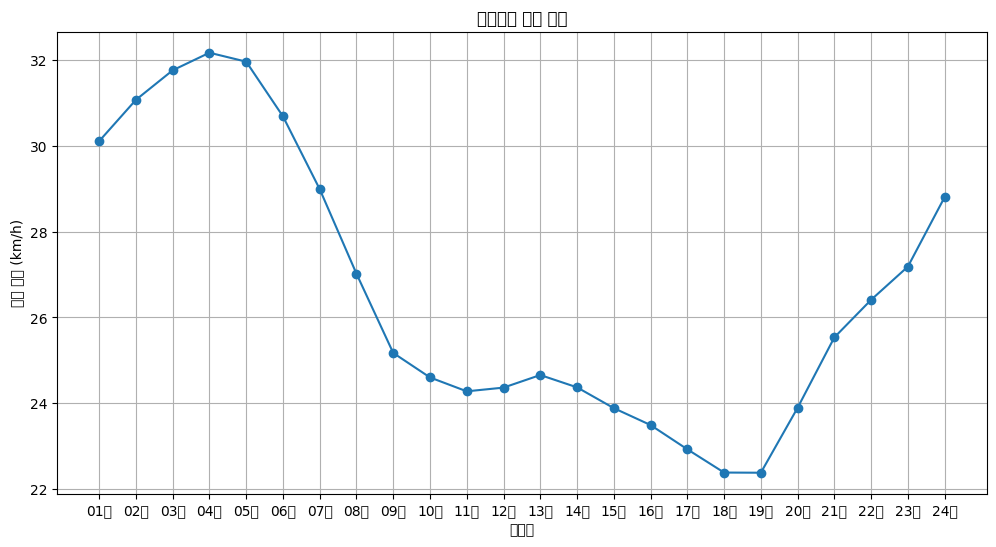

In [106]:
from pyspark.sql.functions import col, mean
import matplotlib.pyplot as plt

# 시간대 컬럼 리스트
time_columns = [f"{str(i).zfill(2)}시" for i in range(1, 25)]

# 시간대별 평균 속도 계산
time_avg_speed = speed_df.select(
    *[mean(col(c).cast("float")).alias(c) for c in time_columns]
).toPandas()

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(time_avg_speed.columns, time_avg_speed.iloc[0], marker='o')
plt.title("시간대별 평균 속도")
plt.xlabel("시간대")
plt.ylabel("평균 속도 (km/h)")
plt.grid()
plt.show()